In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

from ml_functions import RF_regressor, plot_importances
from visual_func import create_testdf, plot_std_lat, plot_residuals

In [2]:
arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/0106all.pkl'
arctic_df = pd.read_pickle(arctic_pkl)

## Final model


In [3]:
import math
def Tu_label(data_series):
    """
    Apply labels to Turner angle values based on
    https://www.teos-10.org/pubs/gsw/pdf/Turner_Rsubrho.pdf

    Parameters:
        data_series (pd.Series): Series of Turner angle values.

    Returns:
        pd.Series: Series with labels assigned to Turner angle values.
    """
    # Define the conditions and labels
    conditions = [
        data_series.isnull(),
        (data_series >= -90) & (data_series < -45),
        (data_series >= -45) & (data_series < 45),
        (data_series >= 45) & (data_series < 90),
        (data_series >= 90) & (data_series < -90)
    ]
    labels = ['NaN', 'Diffusive Convection', 'Doubly stable',
              'Salt fingering', 'Statically unstable']

    # Apply the conditions and labels to create a new series with the labels
    result = np.select(conditions, labels, default=0)

    # Create a new series with the labels
    labeled_series = pd.Series(result, index=data_series.index)

    return labeled_series


def encode_tulabel(data):
    # Create an instance of the LabelEncoder
    label_encoder = LabelEncoder()
    # Fit the encoder on the Tu_label column
    label_encoder.fit(data['Tu_label'])
    # Transform the Tu_label column into numeric representation
    numeric_labels = label_encoder.transform(data['Tu_label'])
    # Replace the Tu_label column with the numeric labels
    data['Tu_label'] = numeric_labels
    return data


def plot_importances(
    var_col_names,
    importances,
    num_params_to_show: int = None,
    ax=None
):
    """Visualise feature importance"""
    # initialise axes if necessary
    ax = ax or plt.gca()

    data = dict(zip(var_col_names, importances))
    sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))
    
    # if specified to show fewer, remove all but greatest n values
    if type(num_params_to_show) == int:
        nth_val = sorted(sorted_data.values(), reverse=True)[num_params_to_show-1]
        sorted_data = {k: v for k, v in sorted_data.items() if v >= nth_val}
        
    ax.barh(list(sorted_data.keys()), list(sorted_data.values()))

    # formatting
    ax.set_ylabel('Input variable')
    ax.set_xlabel('Feature importance')

    if type(num_params_to_show) == int:
        ax.set_title(f'Feature importance for model\nTop {num_params_to_show} most significant features', fontsize=18)
    else:
        ax.set_title('Feature importance for model\nAll features', fontsize=18)

    ax.grid(which='both', linewidth=0.3)
    ax.set_xlim(right=1.15*max(importances))

    for i, v in enumerate(sorted_data.values()):
        ax.text(v+.02*max(importances), i, f'{v:.3f}', ha='left', va='center_baseline')
    return ax

In [7]:


def RF_regressor(dataframe, xfeatures, yfeatures):
    if "Tu_label" in xfeatures:
        hallo = Tu_label(dataframe.Tu)
        dataframe["Tu_label"] = hallo

        dataframe = encode_tulabel(dataframe)

    # dataframe['log_eps'] = dataframe['eps'].apply(lambda x: math.log(x))

    # stop depth at 300m
    dataframe = dataframe[dataframe["depth"] <= 300]

    x = dataframe[xfeatures]
    y = dataframe[yfeatures]

    # Split into train and test sets
    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

    # Define the MinMaxScaler
    scaler = MinMaxScaler()

    # Define the RandomForestRegressor
    rfr = RandomForestRegressor(random_state=SEED)

    # Create a pipeline
    pipeline = Pipeline([('scaler', scaler), ('rfr', rfr)])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Obtain feature importances
    importances = rfr.feature_importances_
    return pipeline, y_test, X_test, importances

In [8]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']
pipeline, y_test, X_test, importances = RF_regressor(arctic_df, xstringlist, ystringlist)

In [9]:
# Predict the test set labels
y_pred = pipeline.predict(X_test)
r2_score(y_test, y_pred)

0.8655604435311609

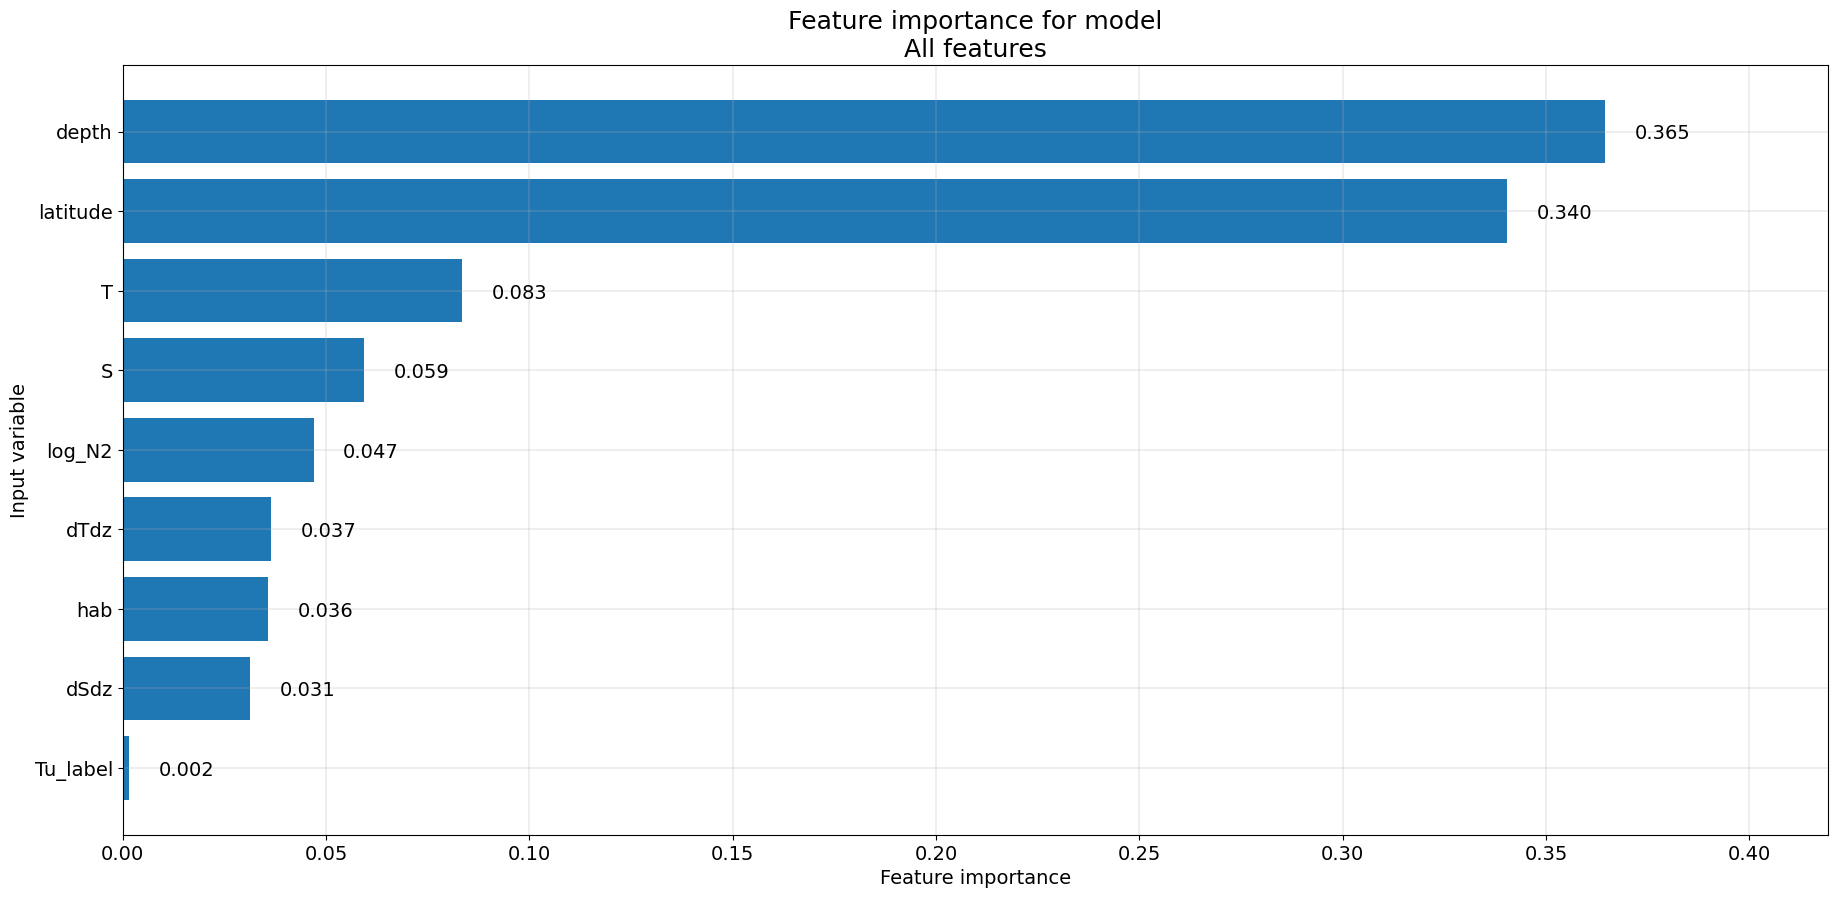

In [10]:
fig = plt.figure(figsize=[22, 10])
ax_imp = fig.add_subplot(1, 1, 1)

plot_importances(xstringlist, importances, ax=ax_imp)
plt.show()

In [14]:
y_test = pd.DataFrame(y_test, columns=["log_eps"])

In [16]:
y_pred = pd.DataFrame(y_pred, columns=["log_eps"])

Text(0.5, 1.0, 'Predictions from RandomForestClassifier')

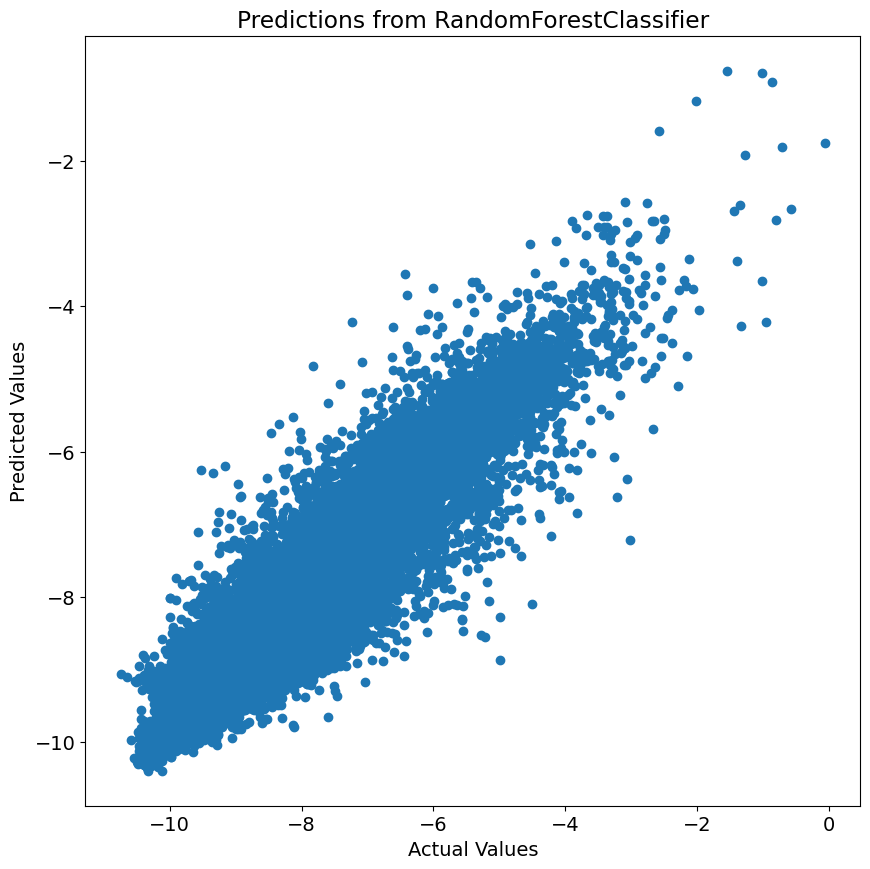

In [22]:
plt.scatter(y_test, y_pred)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions from RandomForestClassifier')

Text(0.5, 1.0, 'Density Plot of Residuals')

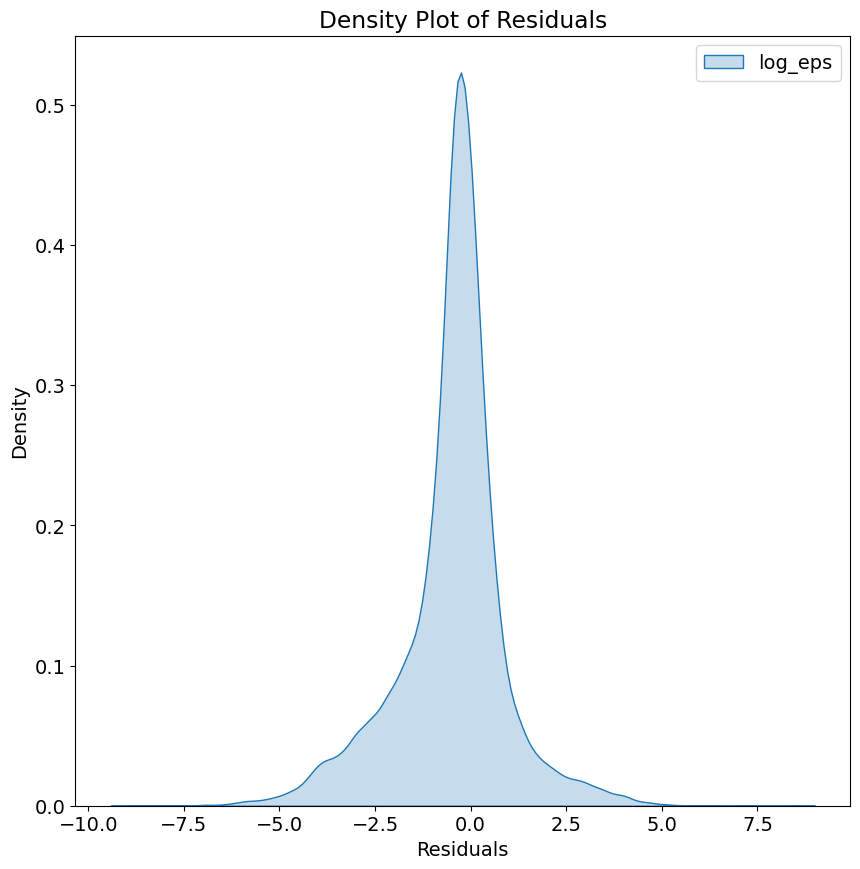

In [25]:
import seaborn as sns

residuals = y_pred - y_test
sns.kdeplot(data=residuals, shade=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals')

In [13]:
y_test = pd.DataFrame(y_test, columns=["log_eps"])


In [21]:
test_df

,S,T,latitude,hab,depth,dSdz,dTdz,log_N2,Tu_label,index,log_eps,eps_pred
0,34.574616,0.022130,83.179593,-3245.00000,115.00000,0.006851,0.013360,-4.353994,2,27715,-21.675947,NaN
1,16.742775,-0.354836,72.183821,-3560.00000,14.00000,0.004809,-0.032739,-4.472509,1,12479,-19.994159,NaN
2,34.229899,-1.878999,83.282928,-3329.00000,31.00000,0.000362,0.000611,-5.278439,1,10831,-21.721963,NaN
3,34.229899,-1.878999,83.282928,-3329.00000,31.00000,0.000362,0.000611,-5.278439,1,10831,-21.721963,NaN
4,34.915000,4.856829,75.528417,-1595.00000,30.00000,-0.008400,-0.064460,-3.822125,2,10831,-21.721963,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
21729,34.279490,-1.875724,83.004409,-3347.00000,13.00000,-0.000087,0.000464,-5.814516,1,7213,-18.749602,NaN
21730,16.574455,-0.684172,70.041857,-264.00000,36.00000,0.002369,-0.053281,-4.595643,2,31429,-20.231441,NaN
21731,35.054386,3.160408,80.139500,-3096.98950,263.01050,0.000135,-0.000362,-6.030313,2,20696,-20.174946,NaN
21732,35.064050,3.657952,80.135333,-3223.50872,136.49128,-0.001464,-0.018767,-5.118189,3,10717,-22.465692,NaN


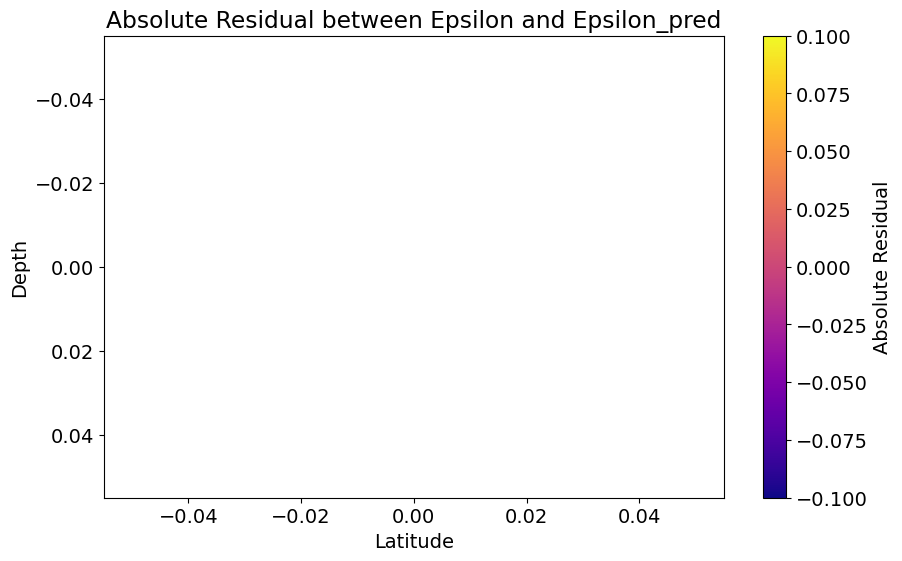

In [20]:
test_df = create_testdf(X_test, df, y_pred)
plot_residuals(test_df)

## Explore arctic_df
More in data_exploration/explore_arctic.ipynb

In [89]:
# need to normalise data or choose an algorithm that deals with this inherently.
arctic_df.describe()

,depth,profile,latitude,longitude,P,S,insituT,T,Tu,Rsubrho,N2,kappa,log_N2,log_kappa,dTdz,dSdz,bathymetry,eps,hab,Tu_label
count,261019.000000,261019.000000,261019.000000,261019.000000,261019.000000,261019.000000,261019.000000,261019.000000,261019.000000,261019.000000,2.610190e+05,2.610190e+05,261019.000000,261019.000000,261019.000000,261019.000000,261019.000000,2.610190e+05,261019.000000,261019.000000
mean,144.053115,754.904716,77.165626,-47.285986,145.057704,27.493855,0.654770,0.649678,-30.936083,0.220532,1.070360e-04,3.347885e-01,-4.805097,-4.693940,0.002381,0.019473,-2828.493684,1.063909e-04,-2684.442573,1.596616
std,132.036972,620.041284,4.916626,79.662009,133.372544,9.153018,2.056985,2.052444,44.592172,135.310169,9.557144e-04,3.524717e+01,0.784220,1.202333,0.078160,0.226864,1143.840116,7.577419e-03,1135.268404,0.702070
min,1.000000,0.000000,65.234802,-175.291467,1.625000,8.038093,-5.655220,-5.643609,-139.358585,-54247.117050,8.586618e-11,1.331517e-09,-10.066178,-8.875653,-2.799255,-0.212505,-3873.000000,1.040818e-11,-3858.000000,0.000000
25%,56.000000,107.000000,72.175232,-139.940751,56.600000,16.639081,-1.259086,-1.257834,-55.760817,-0.031577,4.828597e-06,2.681277e-06,-5.316179,-5.571658,-0.005601,0.000376,-3360.000000,2.901563e-10,-3295.000000,1.000000
50%,118.000000,574.000000,80.273779,7.808481,118.625000,34.330671,0.100960,0.098200,-45.238779,0.046007,1.703436e-05,1.642345e-05,-4.768674,-4.784536,0.000214,0.002587,-3360.000000,1.351488e-09,-3188.000000,1.000000
75%,197.000000,1378.000000,80.899597,11.938414,197.600000,34.927050,2.432911,2.419677,-29.602929,0.453558,4.911363e-05,9.092625e-05,-4.308798,-4.041311,0.012476,0.007262,-3138.000000,2.632948e-09,-2903.408062,2.000000
max,1440.460203,1688.000000,83.309967,162.525117,1461.000000,35.400591,11.063530,11.062550,161.096164,29319.206989,9.179517e-02,1.307534e+04,-1.037180,4.116453,2.013254,7.813100,-11.000000,1.764600e+00,0.000000,3.000000


# Train and test

In [6]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2']

# We want to predict:
ystringlist = ['log_kappa']

#split into x and y, x has features, y is target
x = arctic_df[xstringlist]
y = arctic_df[ystringlist]

In [7]:
from sklearn.model_selection import train_test_split

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [8]:
X_train, X_test, y_train, y_test = X_train.to_numpy(dtype="float"), X_test.to_numpy(dtype="float"), y_train.to_numpy(dtype="float"), y_test.to_numpy(dtype="float")

In [ ]:
# Define the MinMaxScaler
scaler = MinMaxScaler()

# Define the RandomForestRegressor
rfr = RandomForestRegressor(random_state=SEED)

# Create a pipeline
pipeline1 = Pipeline([('scaler', scaler), ('rfr', rfr)])

# Fit the pipeline on the training data
pipeline1.fit(X_train, y_train)

# Predict the test set labels
y_pred = pipeline1.predict(X_test)

In [10]:
# Fit RandomForestClassifier
rfr.fit(X_train, y_train)
# Predict the test set labels
y_pred = rfr.predict(X_test)

In [11]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8930347607334383

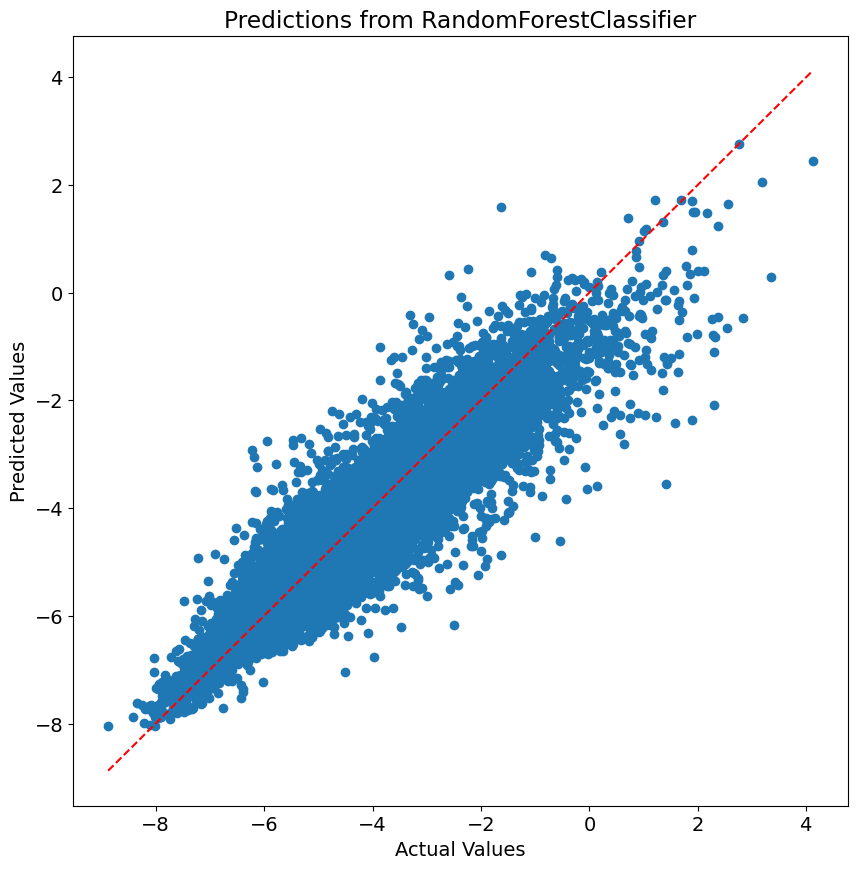

In [100]:
# Create a scatter plot to visualize the predictions
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions from RandomForestClassifier')
plt.show()

In [14]:
importances = rfr.feature_importances_
feature_names = xstringlist
# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Print feature importance rankings with feature names
for i, index in enumerate(sorted_indices):
    feature_name = feature_names[index]
    print(f"Feature #{i+1}: {feature_name} ({importances[index]})")

Feature #1: S (0.2897631314239077)
Feature #2: depth (0.23902151168532007)
Feature #3: log_N2 (0.18534527001163603)
Feature #4: latitude (0.16051274727951592)
Feature #5: T (0.04325705165900132)
Feature #6: hab (0.03634593610243184)
Feature #7: dTdz (0.023594625469173746)
Feature #8: dSdz (0.022159726369013193)


## Extra features

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features
xstringlist2 = ['S', 'T', 'latitude', 'hab', 'depth', 'dSdz', 'dTdz', 'log_N2', 'Tu', 'Rsubrho']

# Target variable
ystringlist = ['log_kappa']

# Split into X and y
X2 = arctic_df[xstringlist2]
y2 = arctic_df[ystringlist]

# Split into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=SEED)

# Define the MinMaxScaler
scaler = MinMaxScaler()

# Define the RandomForestRegressor
rfr2 = RandomForestRegressor(random_state=SEED)

# Create a pipeline
pipeline = Pipeline([('scaler', scaler), ('rfr', rfr2)])

# Fit the pipeline on the training data
pipeline.fit(X_train2, y_train2)

# Predict the test set labels
y_pred2 = pipeline.predict(X_test2)


In [103]:
r2_score(y_test2, y_pred2)

0.8912483143756609

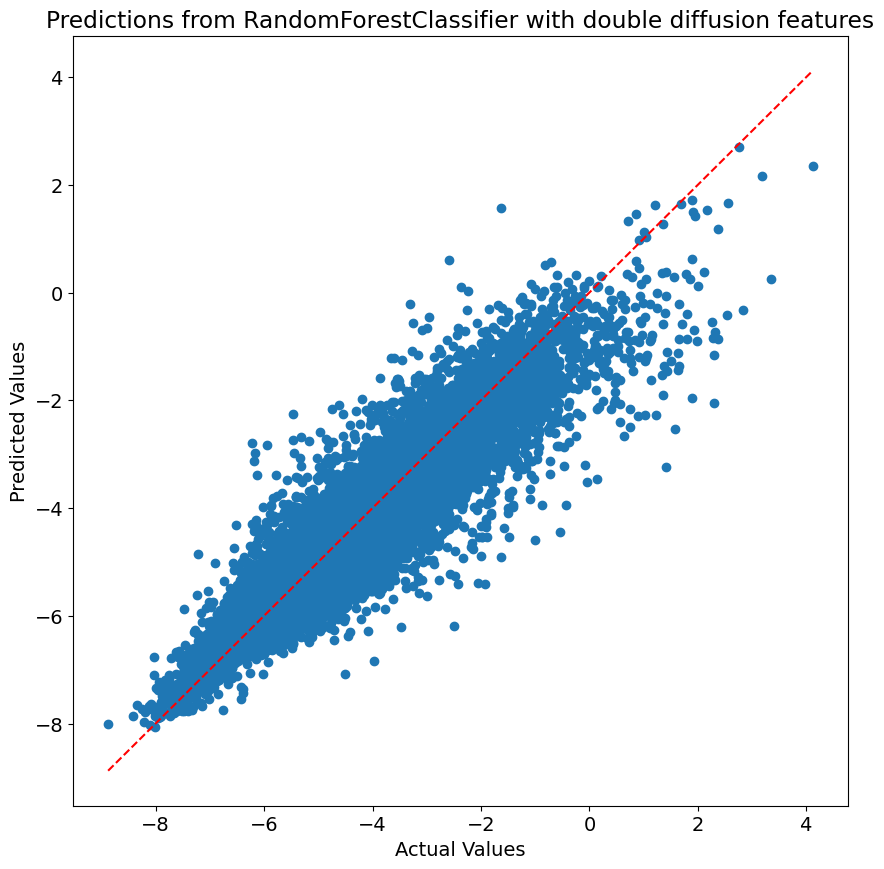

In [106]:
# Create a scatter plot to visualize the predictions
plt.scatter(y_test2, y_pred2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions from RandomForestClassifier with double diffusion features')
plt.show()

In [107]:
importances = rfr2.feature_importances_
feature_names = xstringlist2
# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Print feature importance rankings with feature names
for i, index in enumerate(sorted_indices):
    feature_name = feature_names[index]
    print(f"Feature #{i+1}: {feature_name} ({importances[index]})")

Feature #1: S (0.2863024748091864)
Feature #2: depth (0.23937053302487826)
Feature #3: log_N2 (0.18241936552524887)
Feature #4: latitude (0.15805857477034077)
Feature #5: T (0.040447145235851786)
Feature #6: hab (0.03397454398336469)
Feature #7: dSdz (0.019343822016895492)
Feature #8: dTdz (0.0192383708503803)
Feature #9: Tu (0.013071751628047168)
Feature #10: Rsubrho (0.007773418155806311)


In [112]:
X_test2['index'] = X_test2.index
y_test2['index'] = y_test2.index
# Convert y_pred2 to a dataframe
y_pred2_df = pd.DataFrame(y_pred2, columns=['kappa_pred'])
y_pred2_df["index"] = y_pred2_df.index
# Merge X_test2_reset with arctic_df based on the index column
test2_df = X_test2.merge(y_test2, on='index')
test2_df = test2_df.merge(y_pred2_df, on="index")

In [113]:
# Merge X_test2_reset with arctic_df based on the index column
test2_df = X_test2.merge(y_test2, on='index')
test2_df = test2_df.merge(y_pred2_df, on="index")

In [79]:
# Convert test2_df into a dataset
dataset = xr.Dataset(
    {
        'kappa_pred': xr.DataArray(test2_df['kappa_pred'].values, dims=('depth',)),
    },
    coords={
        'depth': test2_df['depth'].values,
        'latitude': test2_df['latitude'].values,
    }
)

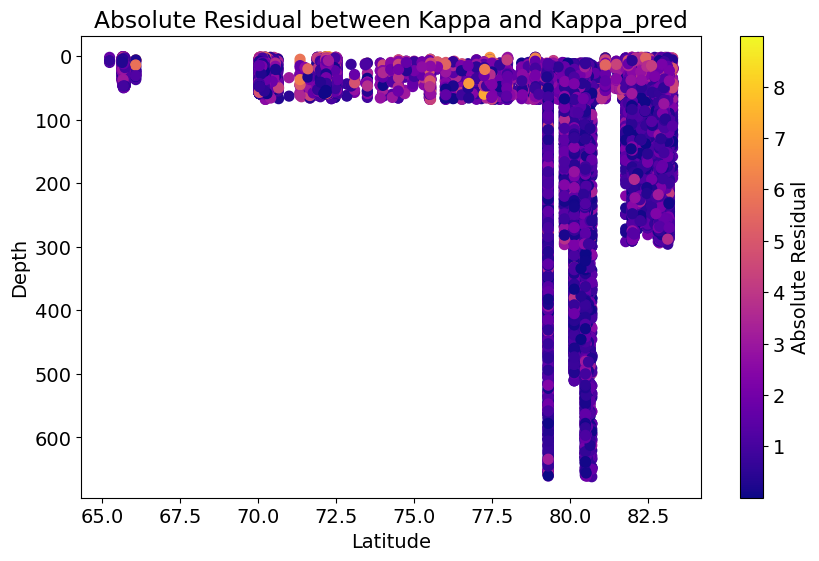

In [135]:
import matplotlib.pyplot as plt

# Calculate the absolute residuals between 'kappa' and 'kappa_pred'
abs_residual = np.abs(test2_df['log_kappa'] - test2_df['kappa_pred'])

# Define the x and y coordinates for the scatter plot
latitude = test2_df['latitude'].values
depth = test2_df['depth'].values

# Create a scatter plot of the absolute residuals
plt.figure(figsize=(10, 6))
plt.scatter(latitude, depth, c=abs_residual, cmap='plasma', s=50)
plt.colorbar(label='Absolute Residual')
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.title('Absolute Residual between Kappa and Kappa_pred')

# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()



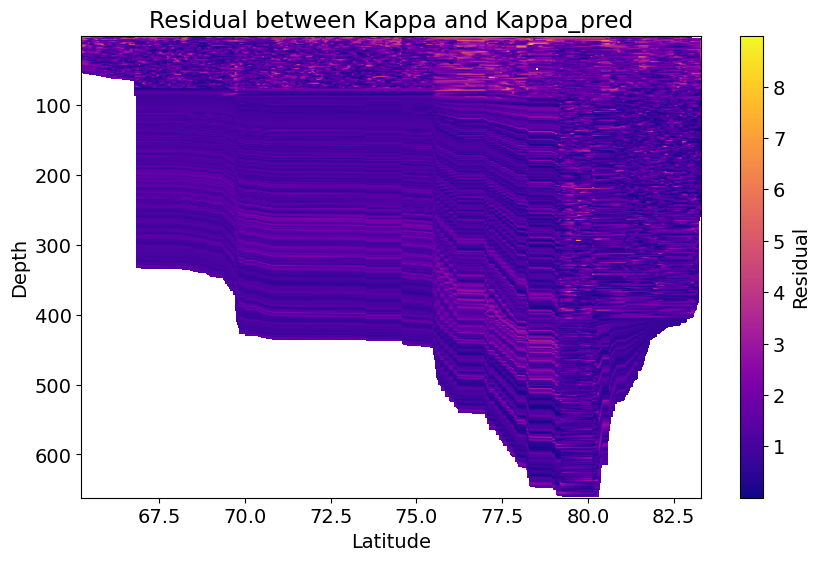

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Assuming test2_df contains 'latitude', 'depth', and 'residual' columns
latitude = test2_df['latitude'].values
depth = test2_df['depth'].values
#residual = test2_df['residual'].values
residual = np.abs(test2_df['log_kappa'] - test2_df['kappa_pred']) #abs

# Define the grid for the plot
unique_latitude = np.unique(latitude)
unique_depth = np.unique(depth)
n_latitude = len(unique_latitude)
n_depth = len(unique_depth)

# Interpolate the residual values to generate a grid
xi, yi = np.meshgrid(unique_latitude, unique_depth)
zi = griddata((latitude, depth), residual, (xi, yi), method='linear')

# Create a 2D plot using imshow
plt.figure(figsize=(10, 6))
plt.imshow(zi, cmap='plasma', extent=[unique_latitude.min(), unique_latitude.max(), unique_depth.max(), unique_depth.min()], aspect='auto')
plt.colorbar(label='Residual')
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.title('Residual between Kappa and Kappa_pred')

# Show the plot
plt.show()


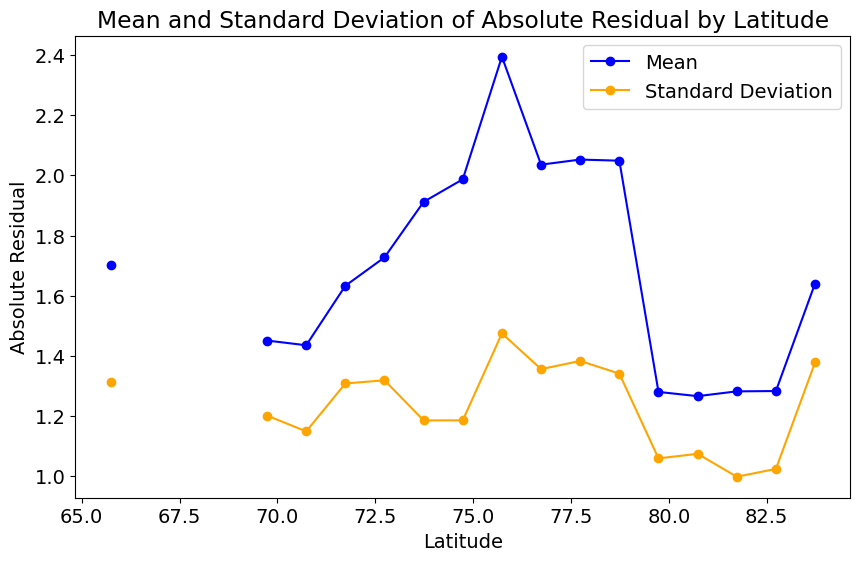

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Calculate the absolute residuals between 'kappa' and 'kappa_pred'
abs_residual = np.abs(test2_df['log_kappa'] - test2_df['kappa_pred'])

# Define the latitude and absolute residual values
latitude = test2_df['latitude'].values
abs_residual_values = abs_residual.values

# Define the binning for latitude
bin_width = 1.0  # Adjust the bin width as desired
lat_bins = np.arange(latitude.min(), latitude.max() + bin_width, bin_width)

# Compute the mean and standard deviation of the absolute residuals for each latitude bin
mean_resid, bin_edges, _ = stats.binned_statistic(latitude, abs_residual_values, statistic='mean', bins=lat_bins)
std_resid, _, _ = stats.binned_statistic(latitude, abs_residual_values, statistic='std', bins=lat_bins)

# Compute the bin centers for plotting
lat_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# Create a line plot of the mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(lat_centers, mean_resid, marker='o', label='Mean', color='blue')
plt.plot(lat_centers, std_resid, marker='o', label='Standard Deviation', color='orange')

# Add labels and title
plt.xlabel('Latitude')
plt.ylabel('Absolute Residual')
plt.title('Mean and Standard Deviation of Absolute Residual by Latitude')

# Add legend
plt.legend()

# Show the plot
plt.show()


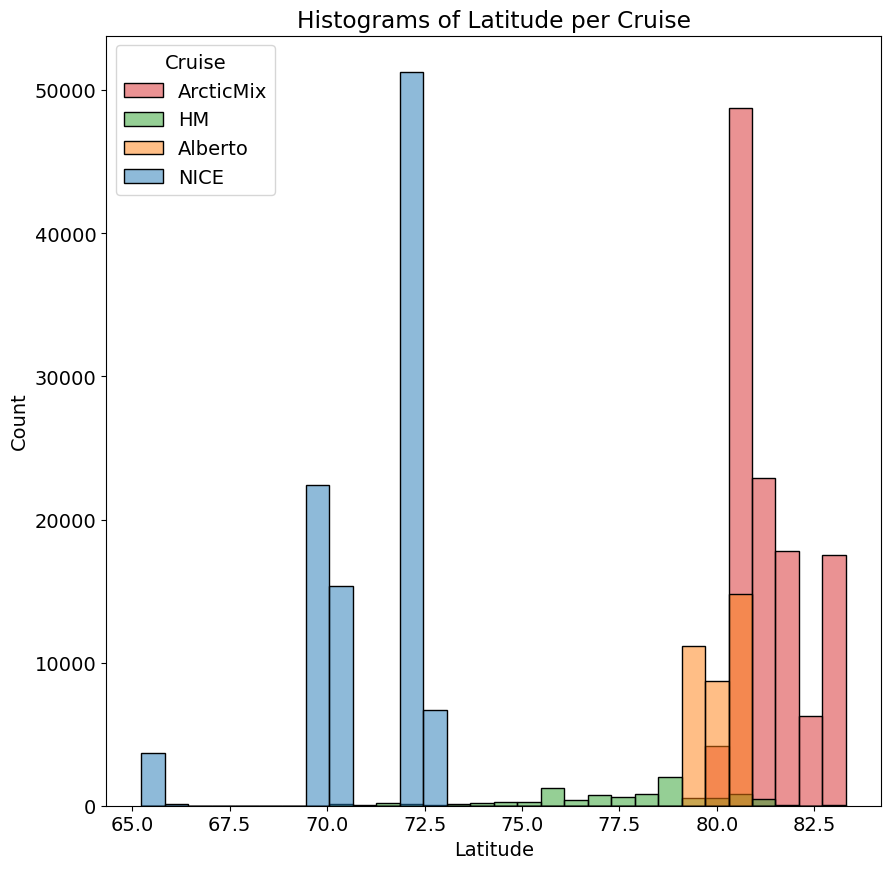

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms of latitude per "cruise" variable
sns.histplot(data=arctic_df, x="latitude", hue="cruise", bins=30)
plt.xlabel("Latitude")
plt.ylabel("Count")
plt.title("Histograms of Latitude per Cruise")
plt.legend(title="Cruise", labels=arctic_df["cruise"].unique(), loc="upper left")
plt.show()


## Do model again but cap depth at 350m

<AxesSubplot:ylabel='Frequency'>

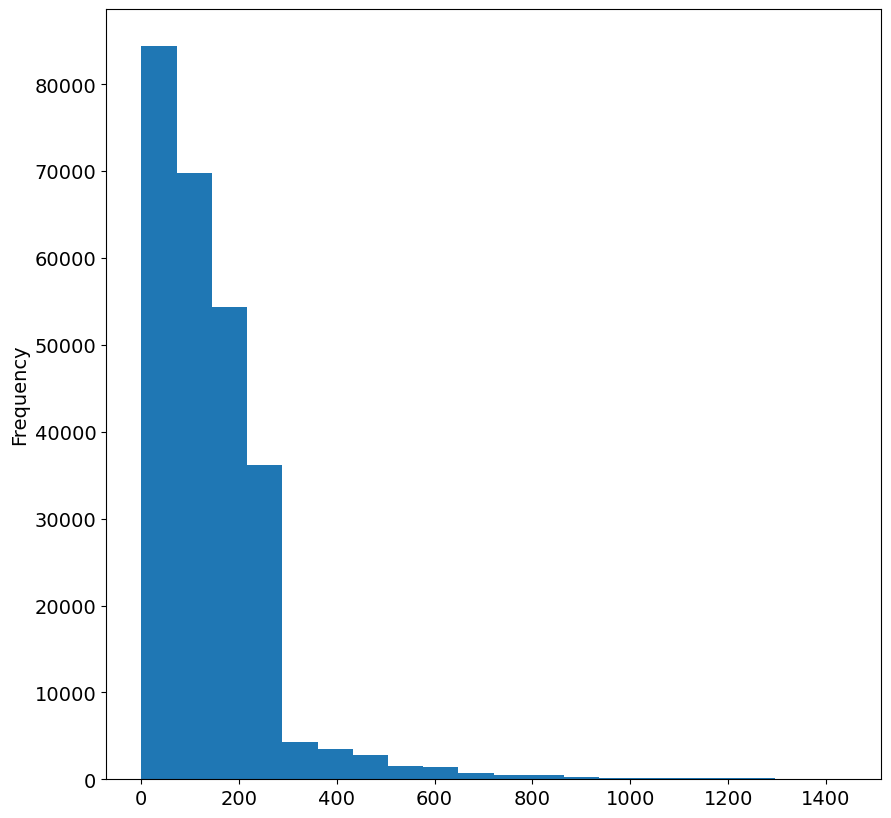

In [60]:
arctic_df.depth.plot.hist(bins=20)